In this notebook I use the [Google Play Top Charts API](https://42matters.com/api/top-google-charts) to look at what (free) apps are top selling, trending, and grossing. 

In [70]:
from collections import Counter
from configparser import ConfigParser
import csv
import matplotlib.pyplot as plt
import numpy as np 
import os
import pandas as pd
from pprint import pprint as pp
import requests
%matplotlib inline

If you want to run this analysis yourself (maybe you want to check other countries), get a 42 matters API key and define a config file called notebook.conf in the same directory as this notebook, with the following values

    [vars]
    apikey = <your_api_key>

## Variables

In [57]:
catkey = "OVERALL"
limit = 100
countries = ("AU", "CL", "CN", "ES", "NL", "US")
dates = ("01-07-2015", "01-07-2016")
cache_file = "google_play_top_charts.csv"

In [58]:
all_list_names = ( "topselling_free", "topselling_paid", "movers_shakers", 
              "topgrossing", "topselling_new_free", "topselling_new_paid" )

In [59]:
list_names = ( "topselling_free", "movers_shakers", "topgrossing")

In [60]:
fieldnames = ("list_name", "country", "date", "title", "cat_key", "category", 
                      "downloads_max", "downloads_min", "lang", "rating")

In [61]:
config = ConfigParser()
config.read("notebook.conf")

['notebook.conf']

In [62]:
access_token = config["vars"]["apikey"]

## Data prep

We only have a limited number of API hits so store the required data in csv to work with

In [148]:
def get_response(lname, country, date):
    url = "https://data.42matters.com/api/v2.0/android/apps/top_google_charts.json?" +\
        "list_name=%s&cat_key=%s&country=%s&limit=%s&access_token=%s&date=%s" % \
    (lname, catkey, country, limit, access_token, date)
    return requests.get(url).json()

In [149]:
def store_response(resp, writeHeader=False):
    list_name = resp["list_name"]
    country = resp["country"]
    date = resp["date"]
    with open(cache_file, 'a') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        if writeHeader:
            writer.writeheader()
        for app in resp["app_list"]:
            writer.writerow({'list_name': list_name, 'country': country, 'date': date,
                            'title': app["title"], 'cat_key': app["cat_key"], 'category': app["category"], 
                             'downloads_max': app["downloads_max"], 'downloads_min': app["downloads_min"], 
                             'lang': app["lang"], 'rating': app["rating"]})

In [158]:
# !! hits = 2 dates x 3 list_names x 6 countries x 3 units per call = 108 
# hence checking if csv file is there and only if not there running this
if not os.path.isfile(cache_file):
    writeHeader = True
    for date in dates:
        for lname in list_names:
            for country in countries:
                try:
                    resp = get_response(lname, country, date)
                    store_response(resp, writeHeader)
                    writeHeader = False
                except:
                    print("ERROR: could not store response for date %s, list_name %s, country %s" % \
                          (date, lname, country))

couple of import errors but most data there to do data analysis :)

    ERROR: could not store response for date 01-07-2015, list_name topselling_free, country CN
    ERROR: could not store response for date 01-07-2015, list_name movers_shakers, country AU
    ERROR: could not store response for date 01-07-2015, list_name movers_shakers, country CL
    ERROR: could not store response for date 01-07-2015, list_name movers_shakers, country CN
    ERROR: could not store response for date 01-07-2015, list_name movers_shakers, country ES
    ERROR: could not store response for date 01-07-2015, list_name movers_shakers, country NL
    ERROR: could not store response for date 01-07-2015, list_name movers_shakers, country US
    ERROR: could not store response for date 01-07-2015, list_name topgrossing, country CN
    ERROR: could not store response for date 01-07-2016, list_name topselling_free, country CN
    ERROR: could not store response for date 01-07-2016, list_name movers_shakers, country CN

In [151]:
os.stat(cache_file).st_size

275601

In [152]:
df = pd.read_csv(cache_file); df.head(2)

,list_name,country,date,title,cat_key,category,downloads_max,downloads_min,lang,rating
0,topselling_free,AU,01-07-2015,Messenger,COMMUNICATION,Communication,5000000000,1000000000,en,3.894
1,topselling_free,AU,01-07-2015,Dark of the Demons,GAME_ROLE_PLAYING,Role Playing,5000000,1000000,en,3.967


In [153]:
df["downloads_medium"] = (df["downloads_max"] + df["downloads_min"] ) /2; df.head(2)

,list_name,country,date,title,cat_key,category,downloads_max,downloads_min,lang,rating,downloads_medium
0,topselling_free,AU,01-07-2015,Messenger,COMMUNICATION,Communication,5000000000,1000000000,en,3.894,3000000000.000
1,topselling_free,AU,01-07-2015,Dark of the Demons,GAME_ROLE_PLAYING,Role Playing,5000000,1000000,en,3.967,3000000.000


## What are the most downloaded games overall?

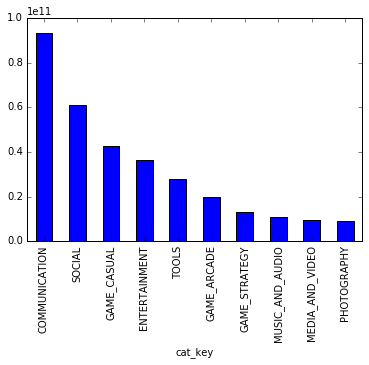

In [154]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
table = pd.pivot_table(df, values='downloads_medium', index=['cat_key'], columns=['country'], aggfunc=np.sum)
table["total"] = table[list(countries)].sum(axis=1)
table["total"].sort_values(ascending=False).head(10).plot(kind="bar")

## And how is that for say Spain, Holland, Australia ?

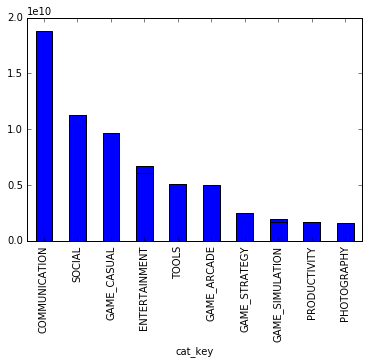

In [155]:
es = table["ES"].sort_values(ascending=False).head(10)
nl = table["NL"].sort_values(ascending=False).head(10)
au = table["AU"].sort_values(ascending=False).head(10)
es.plot(kind="bar", ax=nl.plot(kind="bar"))

In [156]:
table["NL"].sort_values(ascending=False).head(10)

cat_key
COMMUNICATION     16510575300.000
SOCIAL            11235003000.000
GAME_CASUAL        7749000000.000
ENTERTAINMENT      6670005000.000
TOOLS              4025568000.000
GAME_STRATEGY      2555643000.000
GAME_ARCADE        2025037500.000
MUSIC_AND_AUDIO    1953307800.000
PRODUCTIVITY       1638000000.000
GAME_SPORTS        1506300000.000
Name: NL, dtype: float64

In [157]:
table["AU"].sort_values(ascending=False).head(10)

cat_key
COMMUNICATION     17550675000.000
SOCIAL            10278003000.000
GAME_CASUAL        7311750000.000
ENTERTAINMENT      6603900825.000
MUSIC_AND_AUDIO    3135307500.000
TOOLS              2590905000.000
GAME_STRATEGY      2559003000.000
GAME_ARCADE        2214037800.000
PRODUCTIVITY       1626030000.000
GAME_SPORTS        1485105000.000
Name: AU, dtype: float64